In [ ]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [1]:
import pprint as pp

import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Task 2.5: Estimate retention coefficients

## Part C: Exploring retention at vassdragsområde level

This notebook is prompted by a question from Marianne Bechmann received 29.09.2022:

> When I’m talking about nitrogen loss from agriculture and the problems in the Oslofjord, people often ask how much retention we include from source (= agricultural land) to the fjord. The nitrogen loss from e.g. an agricultural area around Hamar, will it be reduced by 50 % before it reaches the Ytre Oslofjord or is the retention much less in the existing Teotil?

This is an interesting question, and it's worth exploring in the context of updating the retention coefficients for the new model. In particular, the old TEOTIL only considers retention in lakes (not rivers), and for large vassdragsområder river retention is likely to be significant. We have discussed this previously with Miljødirektoratet (see [NIVA Report 7726-2022](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y) for details) and decided that including river retention is not within scope for the current development work. However, we may consider adding it during the next stage of development, after we've compared results from the new model to measured fluxes for major catchments from Elveovervåkingsprogrammet.

For now, this notebook will focus on answering Marianne's question, which is a nice starting point for further work.

## 1. Create input file

The code below creates an input file using the new model code. **The code is not finished**, but we can use it to define the basic regine hierarchy, which is all that's needed here.

**Note:** As part of the current development work, I have already updated the estimates of lake volume and residence time (see the notebooks for Task 2.4 [here](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development#task-24-estimate-residence-times)). However, I am still using the old TEOTIL method for estimating retention. **It is likely that retention estimates will change significantly in the new model when these calculations are updated**.

In [3]:
# Define datasets to use
model_year = 2021
nve_data_delivery_year = 2022
regine_data_year = 2022

In [5]:
# Make input dataframe
gdf = teo.io.make_input_file(
    model_year,
    nve_data_delivery_year,
    eng,
    out_csv_fold=None,
    regine_year=regine_data_year,
)

# Keep just relevant columns
cols = [
    "regine",
    "regine_down",
    "vassom",
    "a_cat_land_km2",
    "runoff_mm/yr",
    "q_cat_m3/s",
    "ret_totn",
    "ret_orig-totn",
    "ret_orig-totp",
    "trans_totn",
    "trans_orig-totn",
    "trans_orig-totp",
    "geometry",
]
gdf = gdf[cols]
gdf.head()

100.00 % of regines assigned.


,regine,regine_down,vassom,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s,ret_totn,ret_orig-totn,ret_orig-totp,trans_totn,trans_orig-totn,trans_orig-totp,geometry
0,001.10,001.,001,1.160850,306.979269,0.011284,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,001.,001,1.432412,312.708961,0.014170,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,001.1A1,001,0.340114,228.306190,0.002460,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001.1A20,001,17.647822,266.651052,0.149137,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,001.1A2A,001,41.298255,274.364099,0.359065,0.894915,0.291395,0.885265,0.105085,0.708605,0.114735,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


## 2. Create a "fake" input dataset

To answer Marianne's question, the code below creates a "fake" input dataset where 1000 kg of agricultural total nitrogen and 1000 kg of agricultural total phosphorus are added to a single regine catchment near Hamar. **We will ignore all other inputs** (sewage, industry, natural background etc.) and **assume the contribution from all other regines is also zero**. This is highly simplified, but should illustrate how retention is currently handled in the old TEOTIL.

From a quick look at [NVE Atlas](https://atlas.nve.no/Html5Viewer/index.html?viewer=nveatlas#), regine `002.DC5B` is just north of Hamar. I don't know whether there's much agriculture here, but for this hypothetical experiment it doesn't matter. 

In [6]:
# Regine to add inputs to
reg_id = "002.DC5B"

# Amount to add (kg)
input_totn = 1000
input_totp = 1000

# Create "fake" agricultural inputs
gdf["agri_totn_kg"] = np.where(gdf["regine"] == reg_id, input_totn, 0)
gdf["agri_orig-totn_kg"] = np.where(gdf["regine"] == reg_id, input_totn, 0)
gdf["agri_orig-totp_kg"] = np.where(gdf["regine"] == reg_id, input_totp, 0)

## 3. Run model

In [7]:
%%time

# Drop unwanted columns
df = gdf.drop(
    ["vassom", "ret_totn", "ret_orig-totn", "ret_orig-totp", "geometry"], axis="columns"
)

# Run model
g = teo.model.run_model(df, id_col="regine", next_down_col="regine_down")

CPU times: user 3.82 s, sys: 0 ns, total: 3.82 s
Wall time: 3.81 s


## 4. Explore output

### 4.1. Inputs to the fjord

In [8]:
# Show results for the outflow of Glomma
print("Accumulated attributes for Glomma:")
pp.pprint(g.nodes["002."]["accum"])

Accumulated attributes for Glomma:
{'agri_orig-totn_kg': 821.5970851945507,
 'agri_orig-totp_kg': 234.02615689492634,
 'agri_totn_kg': 308.43221714774,
 'q_m3/s': 593.069778964384,
 'upstr_area_km2': 42412.69555624757}


So, overall, based on NVE's flow data for 2021, the model predicts mean annual flows in Glomma of **593 m3/s**. Of the 1000 kg of TOTP and TOTN added near Hamar, **234 kg of TOTP** is estimated to reach the Oslofjord, compared to **822 kg of TOTN**.

The relative proportions of TOTN and TOTP are broadly what we might expect based on the way the old model estimates N retention for individual lakes as `0.2 * p_retention`. As an aside, note that this does not imply that *accumulated* N retention is `0.2 * p_retention`, since the relationship is non-linear, but for a system with relatively few large lakes the non-linearity is not great. The ratio of N:P retention in the old model is based on the work of [Holtan (1991)](https://niva.brage.unit.no/niva-xmlui/handle/11250/206295?locale-attribute=en), but this is **likely to change in the new version of the model** (see [Section 3.2 of the recent report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=23) for details). 

### 4.2. Maps of transmitted fluxes and retention

In [9]:
# Just focus on Glomma
gdf2 = gdf.query("vassom == '002'")

# Get rivers and lakes
riv_gdf = nivapy.da.read_postgis(
    "physical", "norway_nve_elvis_river_network_line", eng, clip=gdf2
)
riv_gdf = riv_gdf.query("elveorden > 4").to_crs(gdf2.crs)
lake_gdf = nivapy.da.read_postgis(
    "physical", "norway_nve_innsjo_poly", eng, clip=gdf2
).to_crs(gdf2.crs)

Converting to the projection of target dataset (epsg:32633)


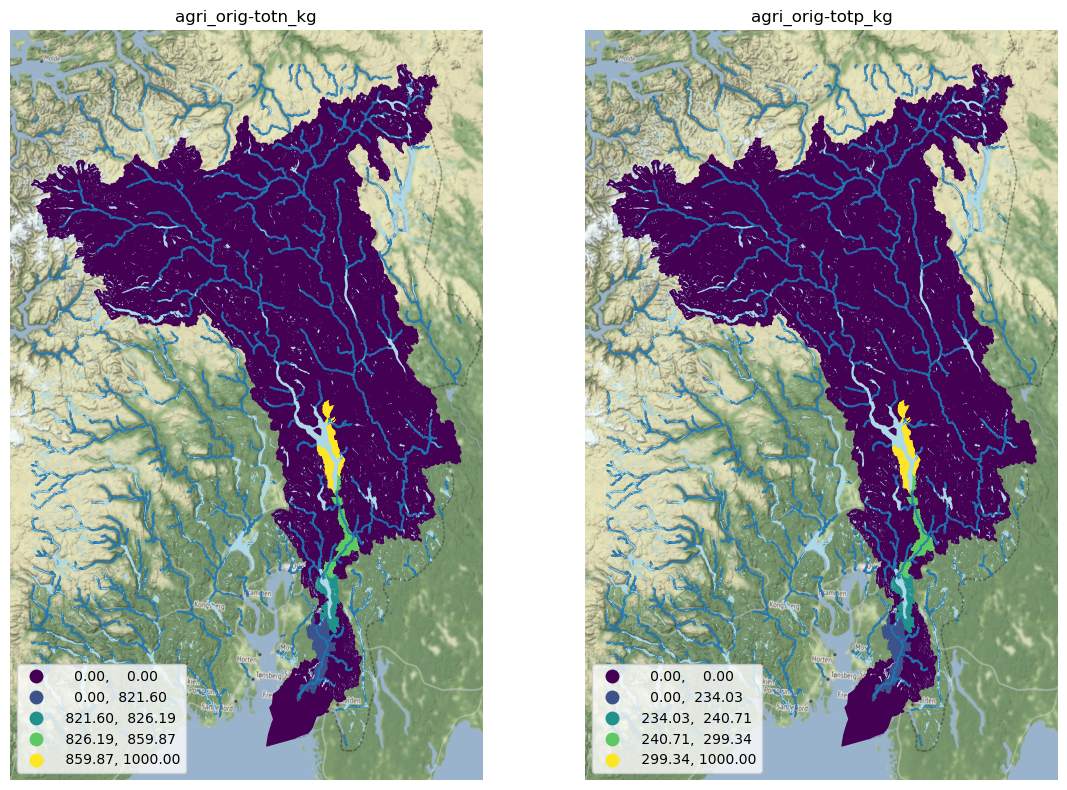

In [10]:
# Maps for TOTN and TOTP
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for idx, par in enumerate(["agri_orig-totn_kg", "agri_orig-totp_kg"]):
    teo.vis.choropleth_map(
        g,
        gdf2,
        id_col="regine",
        stat="accum",
        quant=par,
        trans="none",
        cmap="viridis",
        scheme="natural_breaks",
        n_classes=5,
        ax=axes[idx],
        plot_path=None,
        legend_loc="lower left",
    )
    riv_gdf.plot(ax=axes[idx])
    lake_gdf.plot(ax=axes[idx], facecolor="lightblue", zorder=5)
    cx.add_basemap(axes[idx], crs=gdf2.crs.to_string(), attribution=False)
    axes[idx].set_title(par)
plt.tight_layout()

png_path = "../../images/glomma_transmission_from_hamar.png"
plt.savefig(png_path, dpi=150)

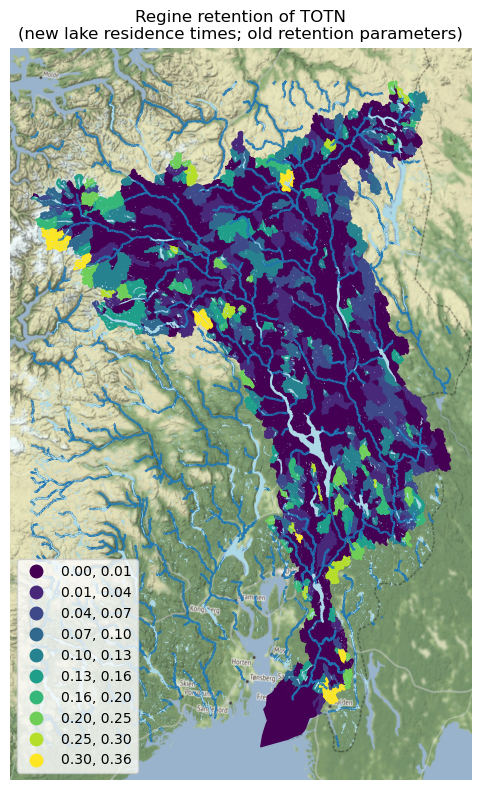

In [11]:
# Map of regine-level TOTN retention
g2 = teo.model.build_graph(gdf, id_col="regine", next_down_col="regine_down")
ax = teo.vis.choropleth_map(
    g2,
    gdf2,
    id_col="regine",
    stat="local",
    quant="ret_orig-totn",
    trans="none",
    cmap="viridis",
    scheme="natural_breaks",
    n_classes=10,
    figsize=(6, 8),
    plot_path=None,
    legend_loc="lower left",
)
riv_gdf.plot(ax=ax)
lake_gdf.plot(ax=ax, facecolor="lightblue", zorder=5)
cx.add_basemap(ax, crs=gdf2.crs.to_string(), attribution=False)
ax.set_title(
    "Regine retention of TOTN\n(new lake residence times; old retention parameters)"
)
plt.tight_layout()

png_path = "../../images/glomma_totn_retention.png"
plt.savefig(png_path, dpi=150)

## 5. Results for all catchments

In [13]:
reg_list = []
trans_to_border_totn = []
trans_to_border_orig_totn = []
trans_to_border_totp = []

for reg_nd in g.nodes:
    g_down = nx.dfs_tree(g, reg_nd)
    totn_list = []
    orig_totn_list = []
    totp_list = []
    for down_nd in list(nx.topological_sort(g_down))[:-1]:
        totn_list.append(g.nodes[down_nd]["local"]["trans_totn"])
        orig_totn_list.append(g.nodes[down_nd]["local"]["trans_orig-totn"])
        totp_list.append(g.nodes[down_nd]["local"]["trans_orig-totp"])
    reg_list.append(reg_nd)
    trans_to_border_totn.append(np.round(100 * np.prod(totn_list), 1))
    trans_to_border_orig_totn.append(np.round(100 * np.prod(orig_totn_list), 1))
    trans_to_border_totp.append(np.round(100 * np.prod(totp_list), 1))
df = pd.DataFrame(
    {
        "regine": reg_list,
        "trans_to_border_totn_pct": trans_to_border_totn,
        "trans_to_border_orig-totn_pct": trans_to_border_orig_totn,
        "trans_to_border_orig-totp_pct": trans_to_border_totp,
    }
)
df.describe()

,trans_to_border_totn_pct,trans_to_border_orig-totn_pct,trans_to_border_orig-totp_pct
count,24068.000000,24068.000000,24068.000000
mean,60.593639,88.855696,61.284299
std,33.823015,12.331097,34.416932
min,0.000000,27.300000,0.100000
25%,30.100000,82.100000,29.300000
50%,62.250000,92.500000,63.700000
75%,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000


In [ ]:
# Maps for TOTN and TOTP
trans_gdf = pd.merge(gdf[["regine", "geometry"]], df, how="left", on="regine")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
for idx, par in enumerate(
    [
        "trans_to_border_totn_pct",
        "trans_to_border_orig-totn_pct",
        "trans_to_border_orig-totp_pct",
    ]
):
    trans_gdf.plot(
        column=par,
        cmap="viridis",
        scheme="natural_breaks",
        k=8,
        ax=axes[idx],
        legend=True,
        legend_kwds={"loc": "upper left"},
    )
    cx.add_basemap(axes[idx], crs=gdf2.crs.to_string(), attribution=False)
    axes[idx].set_title(par)
    axes[idx].axis("off")
plt.tight_layout()

# png_path = "../../images/glomma_transmission_from_hamar.png"
# plt.savefig(png_path, dpi=150)